In [1]:
import os
import json
import numpy as np
import torch as th
import motornet as mn
import pickle
import matplotlib.pyplot as plt

from my_policy import ModularPolicyGRU # the RNN
from my_env    import ExperimentEnv  # the environment
from my_task   import ExperimentTask # the task
from my_utils  import run_episode    # run a batch of simulations
from my_utils  import plot_losses    # for plotting loss history
from my_utils  import plot_handpaths # for plotting hand paths
from my_utils  import plot_signals_modular   # for plotting inputs and outputs per trial
from my_utils  import save_model_modular # for saving model config, weights, losses to disk
from my_utils  import load_model_modular # for loading model config and weights from disk

print('All packages imported.')
print('pytorch version: ' + th.__version__)
print('numpy version: ' + np.__version__)
print('motornet version: ' + mn.__version__)


All packages imported.
pytorch version: 2.8.0
numpy version: 2.3.3
motornet version: 0.2.0


In [2]:
# LOAD A MODEL AND TEST IT ON CENTER-OUT REACHES

save_name = "demo1_modular"

n_tg     = 8    # number of targets for center-out task
sim_time = 3.00 # simulation time (seconds)
FF_k     = 0    # FF strength

print(f"loading model {save_name}")
env,task,policy,device = load_model_modular(os.path.join(save_name,f"{save_name}_cfg.json"), os.path.join(save_name,f"{save_name}_weights.pkl"))

n_t = int(sim_time / env.dt)           # number of simulation steps
task.run_mode = 'test_center_out'      # center-out reaches

print(f"simulating {task.run_mode}")
episode_data = run_episode(env, task, policy, n_tg, n_t, device, k=FF_k) # run the batch forwards


loading model demo1_modular
simulating test_center_out


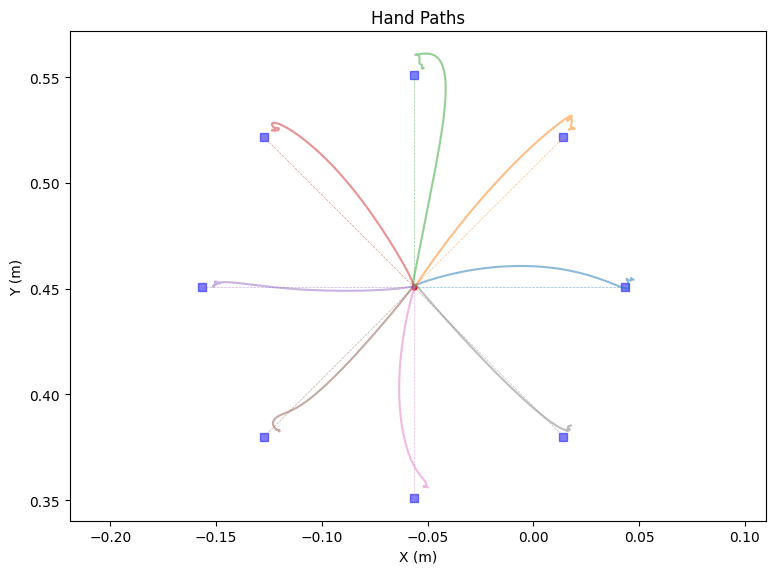

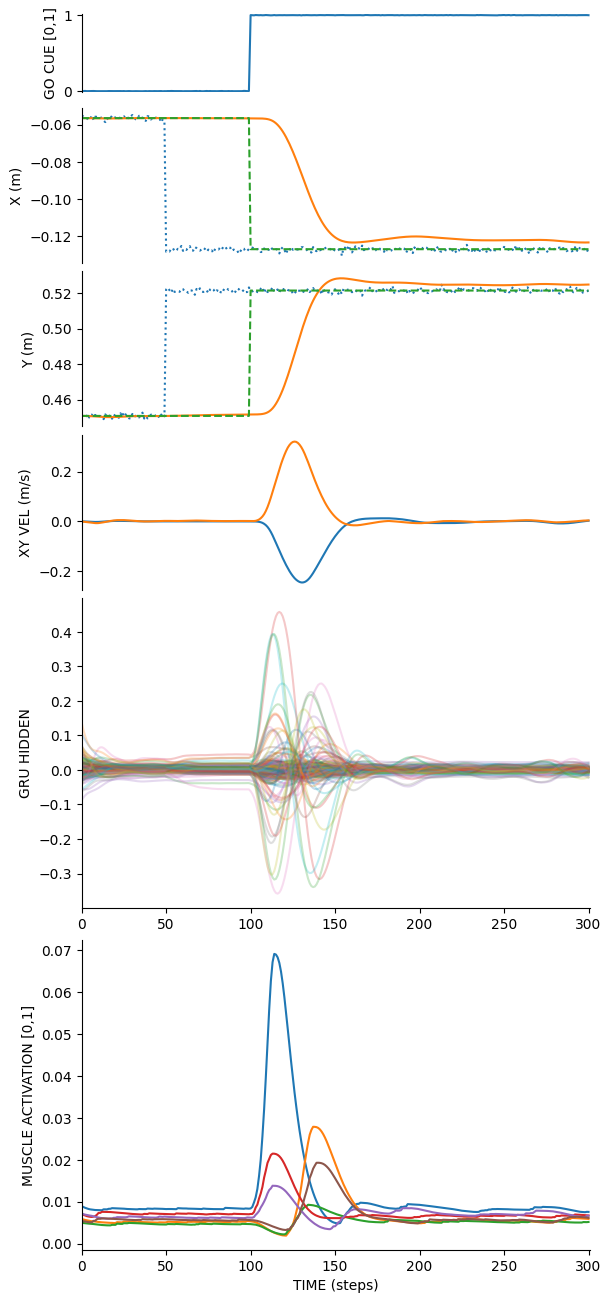

(<Figure size 600x1300 with 6 Axes>,
 [<Axes: ylabel='GO CUE [0,1]'>,
  <Axes: ylabel='X (m)'>,
  <Axes: ylabel='Y (m)'>,
  <Axes: ylabel='XY VEL (m/s)'>,
  <Axes: ylabel='GRU HIDDEN'>,
  <Axes: xlabel='TIME (steps)', ylabel='MUSCLE ACTIVATION [0,1]'>])

In [3]:
# Plot results
plot_handpaths(episode_data=episode_data)
plot_signals_modular(episode_data=episode_data, trial=3)

In [4]:
h_all = episode_data['hidden'].detach().numpy()
print(f"hidden activity shape: {np.shape(h_all)}")

hidden activity shape: (8, 301, 544)


In [5]:
h_pmd = h_all[:,:,0:policy.module_size[0]]
h_m1  = h_all[:,:,policy.module_size[0]:policy.module_size[0] + policy.module_size[1]]
h_sc  = h_all[:,:,policy.module_size[0] + policy.module_size[1]:policy.module_size[0] + policy.module_size[1] + policy.module_size[2]]
print(f"PMd hidden activity shape: {np.shape(h_pmd)}")
print(f"M1 hidden activity shape: {np.shape(h_m1)}")
print(f"SC hidden activity shape: {np.shape(h_sc)}")

PMd hidden activity shape: (8, 301, 256)
M1 hidden activity shape: (8, 301, 256)
SC hidden activity shape: (8, 301, 32)


In [6]:
h = h_m1

In [7]:
# Mean across conditions
n_mean = np.mean(h, axis=0, keepdims=True)

# Range across conditions
n_range = np.max(h, axis=0, keepdims=True) - np.min(h, axis=0, keepdims=True)

# Scale
h = (h - n_mean) / (n_range + 5)

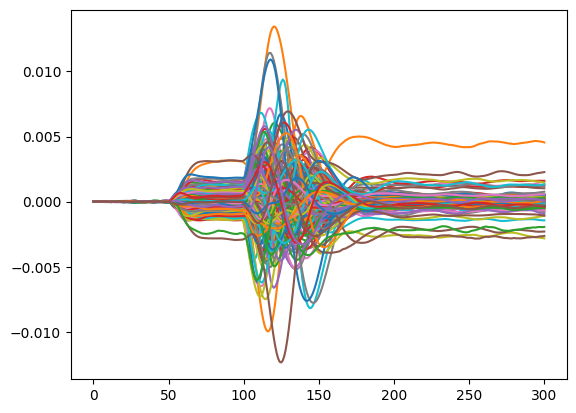

In [8]:
plt.figure()
plt.plot(h[0,:,:])
plt.show()

In [9]:
from sklearn.decomposition import PCA

# X shape: (time, condition, neurons)
X = np.transpose(h,(1,0,2))   # (301, 8, 256)

# Reshape for PCA: (samples, features)
X_flat = X.reshape(-1, X.shape[-1])   # -> (2408, 256)

# Run PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_flat)     # (2408, 3)

# Reshape back to (time, condition, PCs)
X_pca = X_pca.reshape(X.shape[0], X.shape[1], 3)  # -> (301, 8, 3)

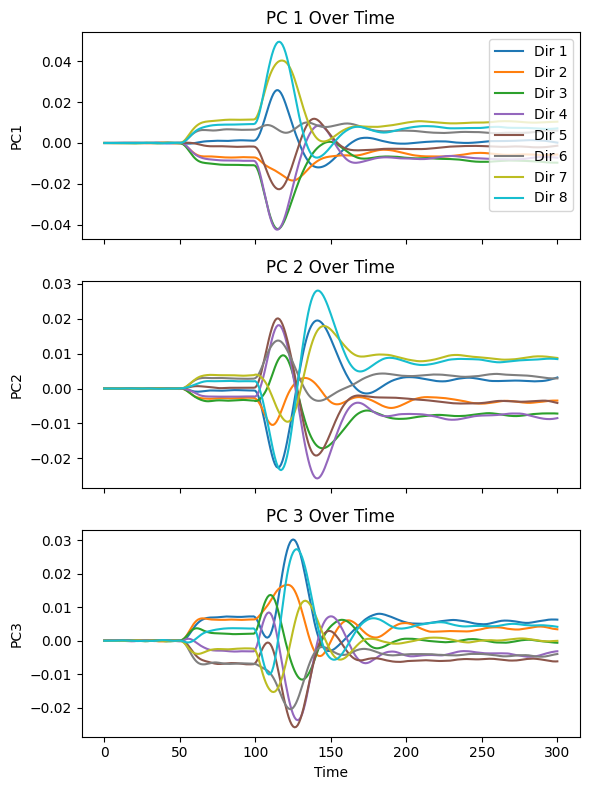

In [10]:
time = np.arange(X_pca.shape[0])
colors = plt.cm.tab10(np.linspace(0, 1, X_pca.shape[1]))

fig, axes = plt.subplots(3, 1, figsize=(6, 8), sharex=True)

for i, ax in enumerate(axes):
    for cond in range(X_pca.shape[1]):
        ax.plot(time, X_pca[:, cond, i], color=colors[cond], label=f"Dir {cond+1}" if i==0 else None)
    
    ax.set_ylabel(f"PC{i+1}")
    ax.set_title(f"PC {i+1} Over Time")

axes[-1].set_xlabel("Time")
axes[0].legend(loc='upper right')

plt.tight_layout()
plt.show()

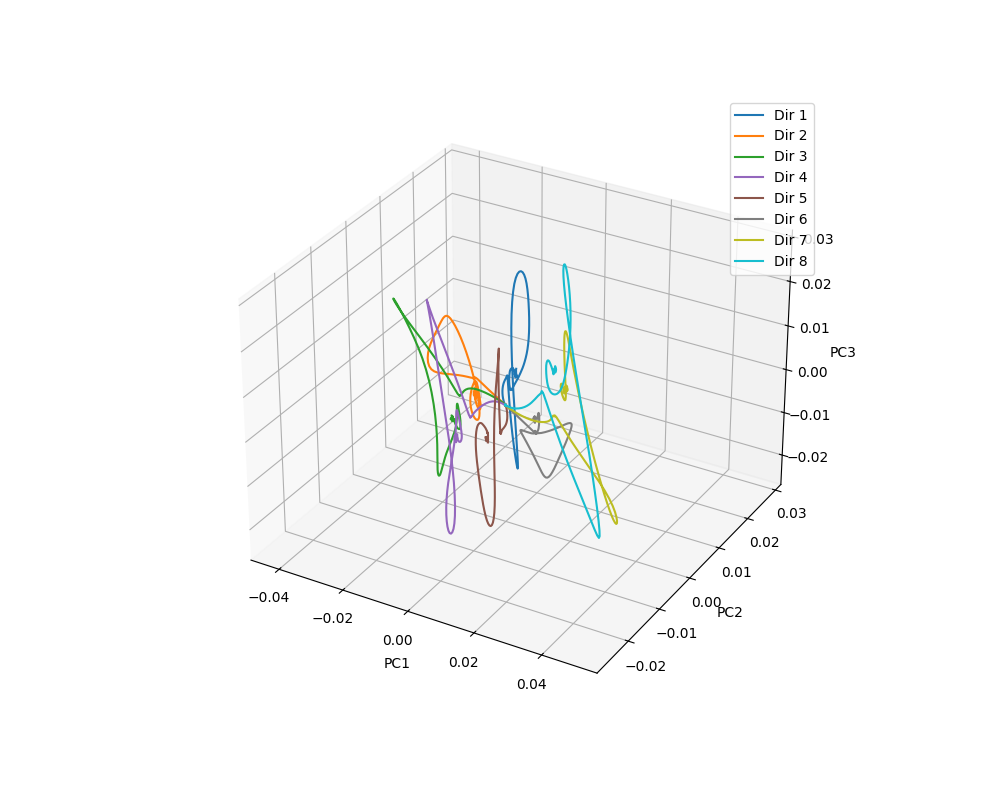

In [11]:
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D projection

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = plt.cm.tab10(np.linspace(0, 1, X.shape[1]))

for cond in range(X.shape[1]):
    ax.plot(
        X_pca[:, cond, 0], 
        X_pca[:, cond, 1], 
        X_pca[:, cond, 2], 
        color=colors[cond], 
        label=f"Dir {cond+1}"
    )

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()

plt.show()